In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Reshape, Concatenate, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model
import os

In [2]:
context_window=(26,26)
batch_size=32

In [3]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\Train\Images",
    color_mode='rgb',
    image_size=context_window,
    batch_size=128,
    shuffle=False,
)

Found 18001 files belonging to 9 classes.


In [4]:
test_dataset=tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\Test\Images",
    color_mode='rgb',
    image_size=context_window,
    batch_size=128,
    shuffle=False,
)

Found 4493 files belonging to 9 classes.


In [5]:
def LSTM_model(input_shape=(26,26,3),n_a=512, n_values=9, context_window=26):
    initializers = tf.keras.initializers.RandomNormal(seed=1)

    reshaper = Reshape((1,input_shape[1]*input_shape[2]))
    LSTMcell = LSTM(n_a, return_state=True, kernel_initializer=initializers)
    Densor1 = Dense(n_a/2, kernel_initializer=initializers, activation="relu")
    Densor2 = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    concat = Concatenate(axis=-1)
    Densor_softmax = Dense(n_values, kernel_initializer=initializers, activation='linear')
    inputs = Input(shape=input_shape)
    outputs = []
    for i in range(context_window):
        x = inputs[:, i, :, :]
        x = reshaper(x)
        if i==0:
            _, a, c = LSTMcell(x)
        else:
            _, a, c = LSTMcell(x,initial_state=[a,c])
        out = Densor1(a)
        out = Densor2(out)
        outputs.append(out)
    outputs = concat(outputs)
    outputs = Densor_softmax(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [4]:
model = LSTM_model()

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26, 26, 3)]  0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 26, 3)       0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 reshape (Reshape)              (None, 1, 78)        0           ['tf.__operators__.getitem[0][0]'
                                                                 , 'tf.__operators__.getitem_1[0][
                                                                 0]',                         

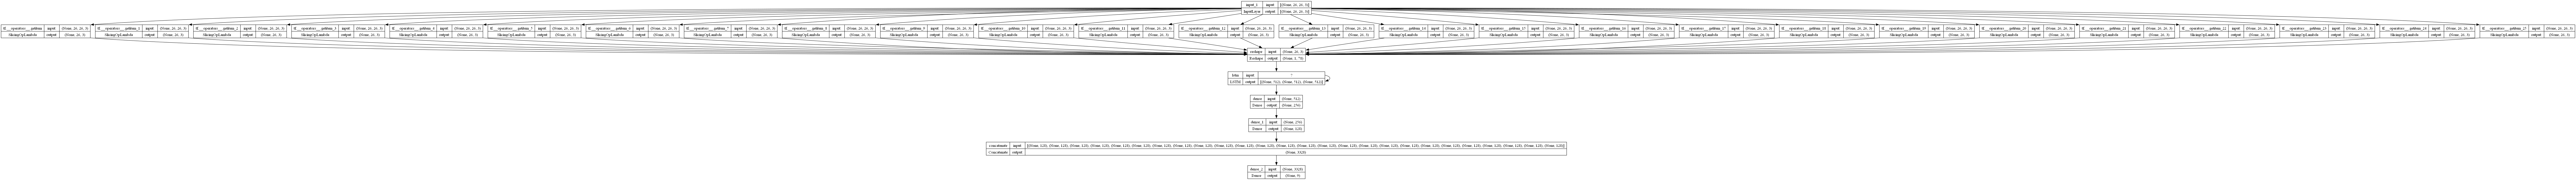

In [11]:
tf.keras.utils.plot_model(model,to_file="Softmax_LSTM_model.png",show_shapes=True)

In [31]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.prev_loss=0
    def on_epoch_end(self,epoch,logs={}):
        model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/LSTM models/model_{epoch}.h5")
        if(epoch>0 and logs.get('loss')>=self.prev_loss):
            print('\nLearning rate updated')
            self.model.optimizer.lr.assign(self.model.optimizer.lr.read_value()*0.1)
        self.prev_loss=logs.get('loss')

callbacks=myCallback()

In [32]:
history=model.fit(train_dataset,validation_data=test_dataset,batch_size=128,epochs=30,callbacks=[callbacks])

Epoch 1/30


141/141 [==============================] - 95s 274ms/step - loss: 1.0068 - accuracy: 0.7433 - val_loss: 1.1168 - val_accuracy: 0.7156
Epoch 2/30
141/141 [==============================] - 24s 169ms/step - loss: 0.4642 - accuracy: 0.8720 - val_loss: 0.5615 - val_accuracy: 0.8422
Epoch 3/30
141/141 [==============================] - 24s 168ms/step - loss: 0.2285 - accuracy: 0.9282 - val_loss: 0.2529 - val_accuracy: 0.9377
Epoch 4/30
141/141 [==============================] - 24s 168ms/step - loss: 0.1033 - accuracy: 0.9794 - val_loss: 0.0616 - val_accuracy: 0.9860
Epoch 5/30
141/141 [==============================] - 23s 165ms/step - loss: 0.0404 - accuracy: 0.9938 - val_loss: 0.0325 - val_accuracy: 0.9929
Epoch 6/30
141/141 [==============================] - 23s 165ms/step - loss: 0.0196 - accuracy: 0.9976 - val_loss: 0.0234 - val_accuracy: 0.9944
Epoch 7/30
141/141 [==============================] - 24s 167ms/step - loss: 0.0112 - accuracy: 0.9989 - val_loss: 0.0196 - val_accuracy: 0.9

In [33]:
# Emergency Save
model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/LSTM models/model_{30}.h5")

In [34]:
import json

with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/LSTM.txt","w") as file:
    file.write(json.dumps(history.params))
with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/LSTM_history.txt","w") as file:
    file.write(json.dumps(history.history))

In [6]:
model=tf.keras.models.load_model(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/LSTM models/model_{29}.h5")

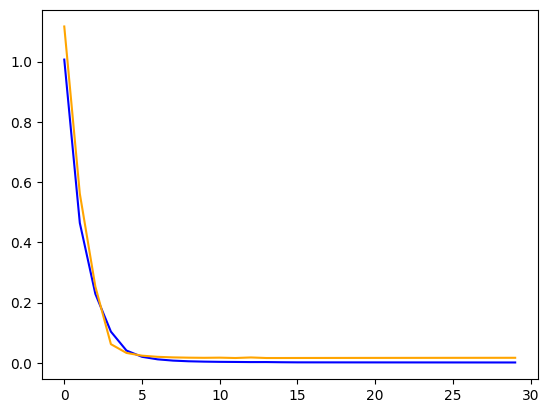

In [36]:
plt.plot(range(30),history.history["loss"],color="blue",label="Train Loss")
plt.plot(range(30),history.history["val_loss"],color="orange",label="Validation Loss")
plt.show()

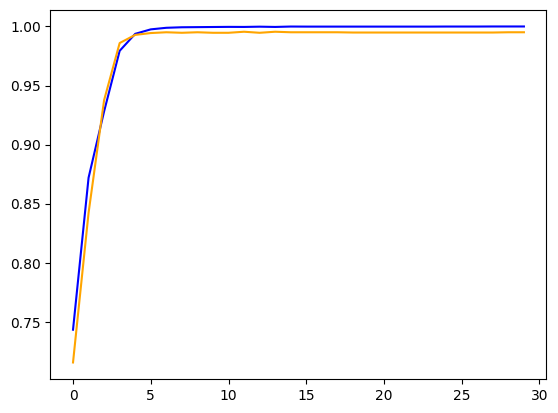

In [37]:
plt.plot(range(30),history.history["accuracy"],color="blue",label="Train Accuracy")
plt.plot(range(30),history.history["val_accuracy"],color="orange",label="Validation Accuracy")
plt.show()

In [7]:
model.evaluate(train_dataset)
model.evaluate(test_dataset)

36/36 [==============================] - 3s 79ms/step - loss: 0.0164 - accuracy: 0.9951


[0.016376372426748276, 0.9951034784317017]

In [8]:
Y_test=np.concatenate([y for x,y in test_dataset],axis=0)

In [9]:
y_predict=np.argmax(tf.nn.softmax(model.predict(test_dataset)),axis=1)

36/36 [==============================] - 16s 69ms/step


In [10]:
confusion_matrix=tf.math.confusion_matrix(Y_test,y_predict)
confusion_matrix

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[3073,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  384,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  384,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,   60,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,   45,    0,    0,    0,    0],
       [   2,    0,    0,    0,    0,   30,   12,    0,    0],
       [   0,    0,    0,    0,    0,    0,   41,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  384,    0],
       [   0,    8,    0,    0,    0,    0,    0,    0,   70]])>

In [11]:
from mlxtend.plotting import plot_confusion_matrix

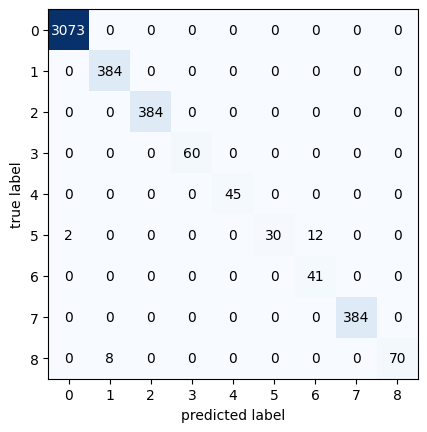

In [12]:
fig,ax=plot_confusion_matrix(confusion_matrix.numpy())
plt.show()